# Model definition (for hap-hd)

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from astropy.convolution import Tophat2DKernel
from regions import CircleSkyRegion, RectangleSkyRegion

from gammapy.detect import compute_lima_on_off_image,compute_lima_image # quelle différence entre les deux ?
from gammapy.data import DataStore
from gammapy.irf import make_mean_psf
from gammapy.maps import Map, MapAxis, WcsGeom
from gammapy.cube import (
    MapDatasetMaker,
    PSFKernel,
    MapDataset,
    RingBackgroundMaker,
    SafeMaskMaker,
    #RingBackgroundEstimator,
)
from gammapy.modeling.models import (
    SkyModel,
    SkyModels,
    BackgroundModel,
    PowerLawSpectralModel,
    PowerLaw2SpectralModel,
    PointSpatialModel,
    ExpCutoffPowerLawSpectralModel,
    SkyDiffuseCube,
    TemplateSpatialModel,
    GaussianSpatialModel
)
from gammapy.stats import significance, excess # utiles ?

from gammapy.modeling import Fit
from astropy.time import Time

src_pos = SkyCoord(359.94, -0.04, unit="deg", frame="galactic")

import gammapy
gammapy.__version__

'0.15'

In [9]:
from pathlib import Path

# Directory for outputs

path = Path("../../../../gammapy_data/GC_variability2020/hap-hd")
path.mkdir(exist_ok=True)

pathm = path/"models"
pathm.mkdir(exist_ok=True)

## Creating the geometry

In [10]:
emin, emax = [0.5, 100] * u.TeV

e_bins = 20

energy_axis = MapAxis.from_bounds(
    emin.value, emax.value, e_bins, unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(10, 8),
    coordsys="GAL",
    proj="CAR",
    axes=[energy_axis],
)

geom2d = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(10, 8),
    coordsys="GAL",
    proj="CAR",
)

emintrue, emaxtrue = [0.3,200] * u.TeV
e_bins_true = 30

energy_axis_true = MapAxis.from_bounds(
    emintrue.value, emaxtrue.value, e_bins_true, unit="TeV", name="energy", interp="log"
)

In [11]:
# Creating the total dataset

mapdataset_tot = MapDataset.create(geom=geom, energy_axis_true=energy_axis_true)

filename = "mapdatasets/mapdataset_tot.fits.gz"
mapdataset_tot = MapDataset.read(path/filename)

## Model for the central source (HESS J1745-290)

In [12]:
src_pos = SkyCoord(359.94, -0.04, unit="deg", frame="galactic")

spatial_model = PointSpatialModel(
            lon_0 = src_pos.l, 
            lat_0 = src_pos.b, 
            frame = "galactic")

spectral_model = PowerLawSpectralModel(
            #emin = 0.5* u.TeV, 
            #emax = 100* u.TeV, 
            reference = 1.0 * u.TeV,
            index = 2.3, 
            amplitude = "2.9e-12 cm-2 s-1 TeV-1")

model = SkyModel(
            spatial_model = spatial_model, 
            spectral_model = spectral_model, 
            name = "SgrA*")

model.parameters["index"].frozen = True
model.parameters["lon_0"].frozen = True
model.parameters["lat_0"].frozen = True
model.parameters["amplitude"].frozen = False
model.parameters["reference"].frozen = True

## Model for a nearby source (G09+01)

In [13]:
pos_G09 = SkyCoord(0.8791,  +0.0893, unit="deg", frame="galactic")

spatial_model2 = PointSpatialModel(
            lon_0 = pos_G09.l, 
            lat_0 = pos_G09.b, 
            frame = "galactic")

spectral_model2 = PowerLawSpectralModel(
            #emin = 0.5* u.TeV, 
            #emax = 100* u.TeV, 
            reference = 1.0 * u.TeV,
            index = 2.3, 
            amplitude = "0.88e-12 cm-2 s-1 TeV-1")

modelG09 = SkyModel(
            spatial_model = spatial_model2, 
            spectral_model = spectral_model2, 
            name = "G0901")

modelG09.parameters["index"].frozen = True
modelG09.parameters["lon_0"].frozen = True
modelG09.parameters["lat_0"].frozen = True
modelG09.parameters["amplitude"].frozen = False

## Modelling the diffuse emission

In [14]:
CSmap = Map.read("$GAMMAPY_DATA/CS_reproj.fits") 

coords = CSmap.geom.get_coord()
lon = coords.skycoord.l.wrap_at(180*u.deg).to_value('deg')
factor = np.exp(-0.5*(lon)**2/1.11**2)
CSmap.data*=factor

CSmap.data = (CSmap.data > 10.0) * CSmap.data

solid_angle_tot = CSmap.geom.solid_angle().sum()


DGC = TemplateSpatialModel(CSmap) 

CC = GaussianSpatialModel(lon_0="0 deg", lat_0="0 deg", sigma="0.11 deg", frame='galactic')

LSC = GaussianSpatialModel(lon_0="0 deg", lat_0="0 deg", sigma="0.97 deg", e=np.sqrt(1-(0.22/0.97)**2), phi="90 deg", frame='galactic') 

mapCC = CC.evaluate_geom(geom2d)*geom2d.solid_angle()
mapLSC = LSC.evaluate_geom(geom2d)*geom2d.solid_angle()
mapDGC = DGC.evaluate_geom(geom2d)*geom2d.solid_angle()

CCmax = np.sum(mapCC)
LSCmax = np.sum(mapLSC)
DGCmax = np.sum(mapDGC)

mapCC = mapCC/CCmax
mapLSC = mapLSC/LSCmax
mapDGC = mapDGC/DGCmax

data_combine = 2.68*mapLSC + 4.3*mapDGC +1.03*mapCC 
carte = Map.from_geom(geom2d)
carte.quantity = data_combine

# in 0.15, saving a model use TemplateSpatialModel loses the base map used as a template, so we need to save it and reference it later in the associated .yaml file
carte.write(path/"models/map_DE_spatial_model", overwrite=True)

Invalid value BUNIT='Count' in FITS header. Setting empty unit.


In [15]:
DE_spatial = TemplateSpatialModel(carte) # à noter : on normalise la carte (le modèle spatial) à cette étape là


powerlaw1 =  PowerLawSpectralModel(
            reference = 1.0 * u.TeV,
            index = 2.3, 
            amplitude = "1.0e-12 cm-2 s-1 TeV-1")

model_diff = SkyModel(
            spatial_model = DE_spatial, 
            spectral_model = powerlaw1, 
            name = "DE_full")

model_diff.parameters["index"].frozen = True
model_diff.parameters["norm"].frozen = True
model_diff.parameters["amplitude"].frozen = False
model_diff.parameters["reference"].frozen = True


model_diff.spatial_model.filename = str(path/"models/map_DE_spatial_model")

## Saving the template of the model

In [16]:
models = model.copy() + modelG09.copy()+ model_diff.copy()
name = "models/models_template.yaml"
models.write(path/name, overwrite=True)

## Constructing the mask

In [17]:
fit_region = RectangleSkyRegion(src_pos, 4*u.deg, 2*u.deg)

#éventuellement étendre le masque

J1745_303_region = CircleSkyRegion(SkyCoord(358.6,  -0.6, unit="deg", frame="galactic"), 0.5 * u.deg)

fit_mask = geom.region_mask([fit_region])*geom.region_mask([J1745_303_region] , inside=False)

fit_mask = Map.from_geom(geom, data=fit_mask)

## Function used to fit a given dataset

In [18]:
def fit_dataset(mapdataset):
    fit = Fit([mapdataset])
    result = fit.run()
    
    table = result.parameters.to_table()
    
    rescov = fit.covariance()
    ampSGRA = mapdataset.models.parameters[3]
    ampdiff = mapdataset.models.parameters[12]
    normbkg = mapdataset.background_model.parameters['norm']
    
    cov= rescov.parameters.get_subcovariance([ampSGRA, ampdiff, normbkg])
    
    return table, cov, result

# Fitting the total dataset

Stacking all three datasets tends to give poor results, trying to fit HESS1+2 on the one hand, and HESS1U on the other might be more succesful.

In [19]:
mapdataset_tot.fit_mask = fit_mask
mapdataset_tot.models =  model.copy() + modelG09.copy()+ model_diff.copy()
mapdataset_tot.background_model.parameters['norm'].value = 1.0

In [20]:
%%time

table, cov, result = fit_dataset(mapdataset_tot)

CPU times: user 58.5 s, sys: 2.2 s, total: 1min
Wall time: 1min


In [21]:
table

name,value,error,unit,min,max,frozen
str9,float64,float64,str14,float64,float64,bool
lon_0,3.599e+02,0.000e+00,deg,nan,nan,True
lat_0,-4.000e-02,0.000e+00,deg,-9.000e+01,9.000e+01,True
index,2.300e+00,0.000e+00,,nan,nan,True
amplitude,2.040e-12,3.266e-14,cm-2 s-1 TeV-1,nan,nan,False
reference,1.000e+00,0.000e+00,TeV,nan,nan,True
lon_0,8.791e-01,0.000e+00,deg,nan,nan,True
lat_0,8.930e-02,0.000e+00,deg,-9.000e+01,9.000e+01,True
index,2.300e+00,0.000e+00,,nan,nan,True
amplitude,6.295e-13,2.126e-14,cm-2 s-1 TeV-1,nan,nan,False


# Results

## Model predictions

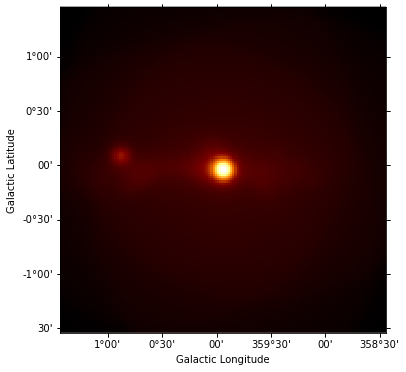

In [22]:
pathma = Path(path/"models/maps")
pathma.mkdir(exist_ok=True)

plt.figure(figsize=(6,6))
mapdataset_tot.npred().sum_over_axes().cutout(src_pos,3*u.deg).smooth('0.05 deg').plot()
plt.savefig(pathma/"model_tot_map.pdf")

## Residuals

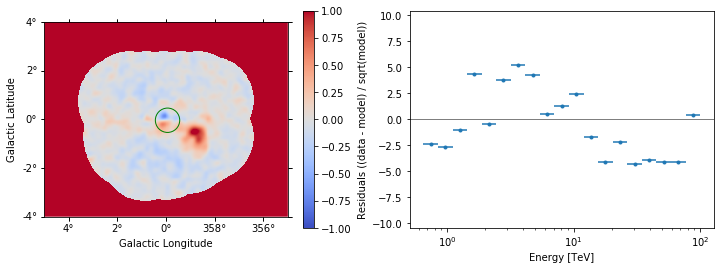

In [23]:
region = CircleSkyRegion(
    center=src_pos, radius=0.5 * u.deg
)

pathr = Path(path/"residuals")
pathr.mkdir(exist_ok=True)

mapdataset_tot.plot_residuals(
        region=region, method="diff/sqrt(model)", vmin=-1.0, vmax=1.0
        )
name = "residuals_tot.pdf"
plt.title("")
plt.savefig(pathr/name, overwrite=True)

## Significance map

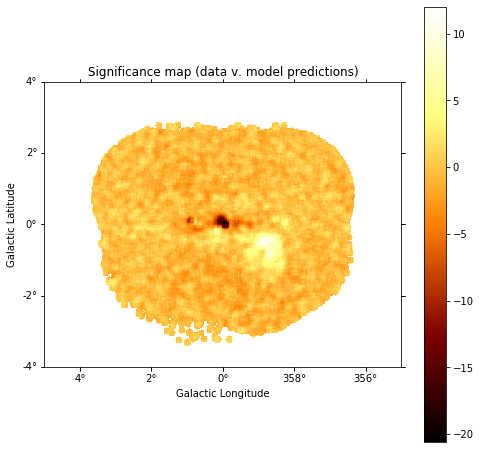

In [24]:
paths = Path(path/"significance")
paths.mkdir(exist_ok=True)

kernel = Tophat2DKernel(5)

plt.figure(figsize=(8,8))
counts = mapdataset_tot.counts.sum_over_axes()
mod = mapdataset_tot.npred().sum_over_axes()
lima_significance = compute_lima_image(counts, mod, kernel)
    
lima_significance['significance'].plot(add_cbar=True)
name = "significance_map_tot.pdf"
plt.title("Significance map (data v. model predictions)")
plt.savefig(paths/name, overwrite=True)

## Significance distribution

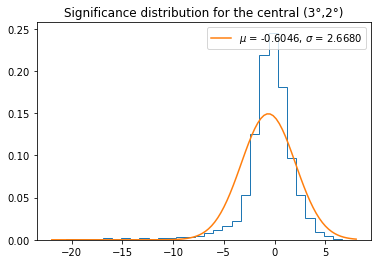

In [25]:
pathh = Path(paths/"significance_distrib")
pathh.mkdir(exist_ok=True)

plt.figure()
signidata = lima_significance['significance'].cutout(position=src_pos, width=(3 * u.deg, 2* u.deg)).data
    
# on masque la région en bas à droite
mask = fit_mask.reduce_over_axes(func=np.logical_or).cutout(position=src_pos, width=(3 * u.deg, 2 * u.deg)).data

plt.hist(signidata[mask].flatten(),30, histtype='step', density=True)
    
mean,std=norm.fit(signidata[mask])
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
y = norm.pdf(x, mean, std)
plt.plot(x, y, label=r'$\mu$ = {0:03.4f}, $\sigma$ = {1:03.4f}'.format(mean,std))
    
plt.legend(loc=1)
    
name = "significance_distribution_tot.pdf"
plt.title("Significance distribution for the central (3°,2°)")
plt.savefig(pathh/name, overwrite=True)